<h2>Exercise 07: Metropolis algorithm for NVT statistical ensamble<h2>

<h5>7-1: With the provided code, compute a large number ( $5\times10^5$ ) of Metropolis moves in the canonical ensamble. Calculate data autocorrelation and test the assumption that the computed statistical uncertainty, due to autocorrelation increases up to a certain block size<h5>

The simulation has been carried out by simply setting blocksize=1 in the simulation input file. First, we take advantage of the calculated averages to detect the equilibration point for each system:

In [1]:
import numpy as np
from myPythonModule import measurements
import myPythonModule as my
import matplotlib.pyplot as plt
import re


In [2]:
#load raw data 
dirname = "exercices/output/dir07"
names = ["solid", "liquid", "gas"]
filenames = []

for name in names:
    filenames.append (["output_" + name + "/output.epot.0", "output_" + name + "/output.pres.0"] )
    
print (filenames)

datasets = []   
for listnames in filenames:
    tempdata=[] 
    for filename in  listnames:
        tempdata.append (measurements(nfields=4, nquantities=1, headed_file_name=dirname + '/' + filename, consumeString = None))
    datasets.append (tempdata)

print ("finished loading")

[['output_solid/output.epot.0', 'output_solid/output.pres.0'], ['output_liquid/output.epot.0', 'output_liquid/output.pres.0'], ['output_gas/output.epot.0', 'output_gas/output.pres.0']]
reading exercices/output/dir07/output_solid/output.epot.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_solid/output.pres.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_liquid/output.epot.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_liquid/output.pres.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_gas/output.epot.0
found headers:  [

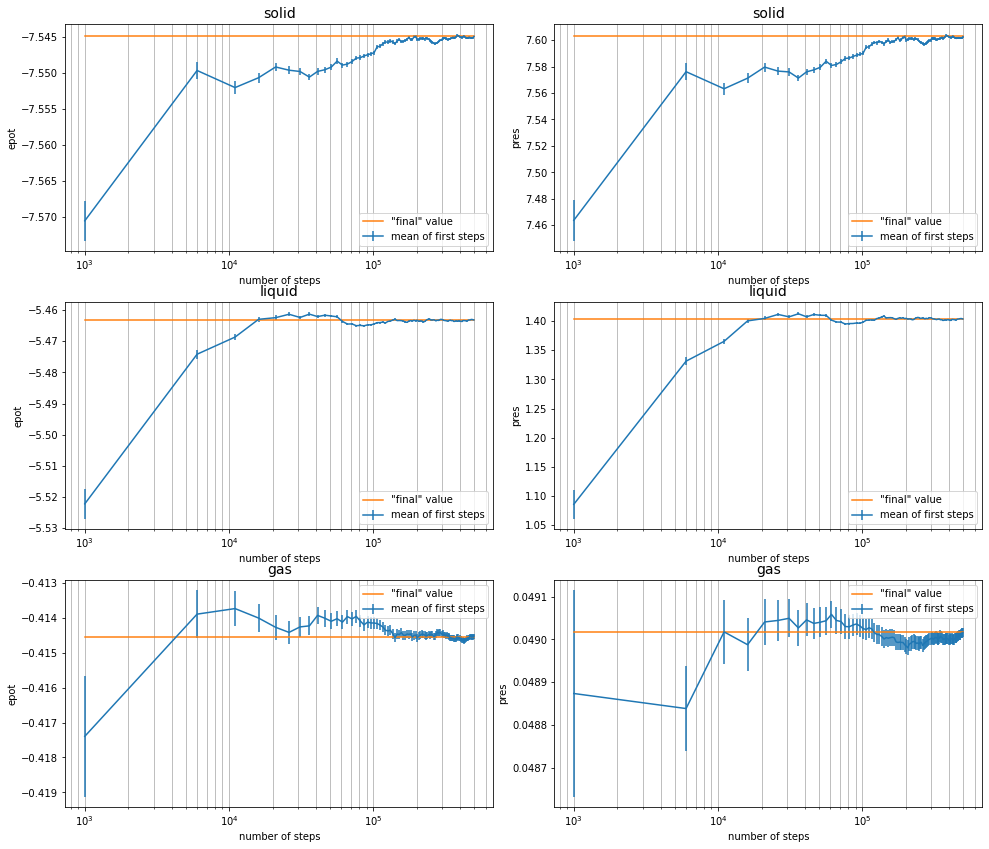

In [3]:
#plot data in order to identify equilibration


fig, axes = plt.subplots (3,2)
fig.set_size_inches((14, 12))
fig.tight_layout (pad=3.)
pickValues = 5000 #we choose to plot only one value every pickValues.
startFrom = 1000  #the very first steps of equilibration are drastic and not very interesting 
                  #if one wishes to determine when the system thermalizes.

    
    
regQuantity = re.compile (r"(?<=put\.)(\w*)(?=\.0)")
regTitle = re.compile (r"(?<=_)(\w*)")

for  ax, listname, twodatasets in zip (axes, filenames, datasets):
    for a, filename, dataset in zip (ax, listname, twodatasets):
        x = dataset.data [0] ["iblock"] [startFrom::pickValues]
        a. errorbar ( x, 
                      dataset.data [0] ["average"] [startFrom::pickValues], 
                      dataset.data [0] ["error"]   [startFrom::pickValues],
                      label="mean of first steps"
                    )
        
        a.plot (x, 
                dataset.data [0] ["average"] [-1] * np.ones (x.shape),
                label="\"final\" value")
        
        a. set_ylabel ( regQuantity.search (filename).group() )
        a. set_xlabel ("number of steps")
        a. grid(True, axis="x", which="both")
        a. set_title ( regTitle.search (filename).group(), fontsize = 14 )
        a. set_xscale ("log")
        a.legend()

            

After the graphs above, it is decided to give the solid, the liquid and the gaseous phase $2\times10^5$, $2\times10^4$ and $1\times10^4$ equilibration steps respectively.

Afterwards, a python script defined in myPythonModule is used in order to compute the autocorrelation between data $t$ steps apart, with $t$ from $1$ to $1000$

In [5]:

a = []
for listnames, twodatasets in zip (filenames, datasets):
    temp_a = []
    for filename, dataset  in zip (listnames, twodatasets):
        temp_a.append (my.autocorrelation (dataset.data [0] ["estimate"], 400))
    a.append (temp_a)



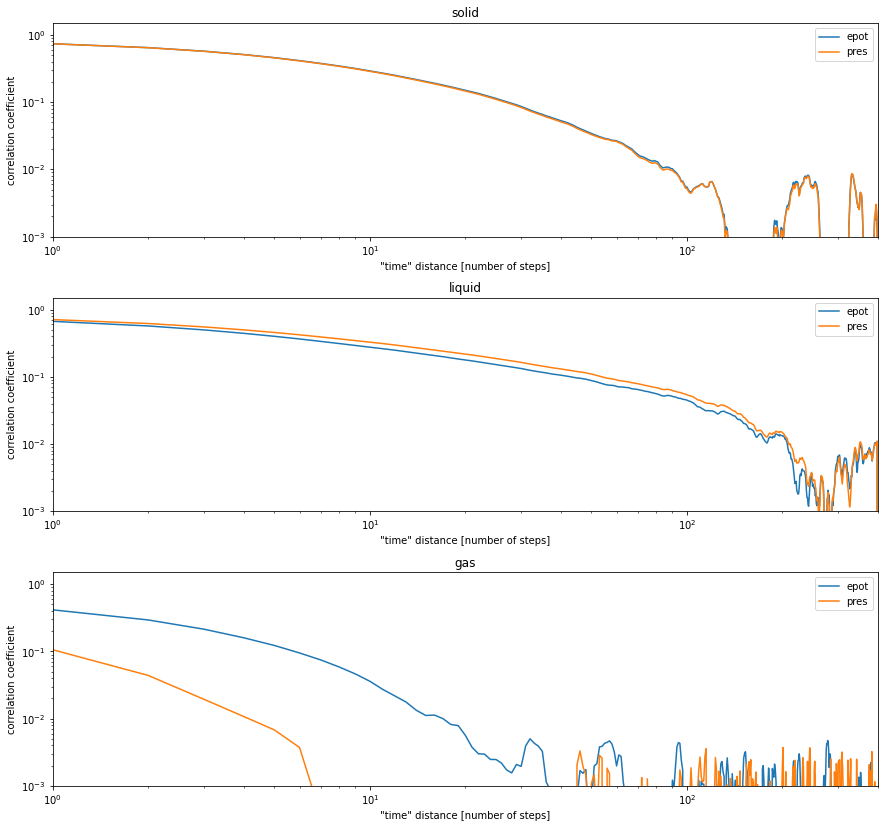

In [6]:
x = range (a[0][0].shape[0])

fig, axes = plt.subplots (3)
fig.set_size_inches (13,12)
fig.tight_layout (pad=4.)

for ax, aut_list , listnames in zip (axes, a, filenames):
    for aut ,filename in zip (aut_list, listnames):
        ax.plot(x, aut, label=regQuantity.search (filename).group())

    ax.set_yscale("log")
    ax.set_ylim([10**(-3), 1.5])
    ax.set_xscale("log")
    ax.set_xlim([1,aut.shape[0]])
    ax.legend ()
    ax.set_title (regTitle.search(filename).group())
    ax.set_ylabel ("correlation coefficient")
    ax.set_xlabel ("\"time\" distance [number of steps]")


As one would expect, correlation in the gaseous phase drops faster than in the liquid and solid one. This may be due to the  bigger steps performed. Also, there is a difference between the gaseous phase and the others, because in the former the pressure and the temperature autocorrelation functions behave rather differently. No obvious explanation can be found for this.

Next, with another Python script, we plot the value of $\sigma(<T>)$ and ($\sigma(<P>)$), as afunction of the blocks size in range $1$ to $5000$

In [7]:
sizes = list (range (1, 5000))

sigmas = []
for dataset_list in datasets:
    sigmas_list = []
    for dataset in dataset_list:
        sigmas_list.append (my.block_sigmas (dataset.data [0] ["estimate"], sizes))
    sigmas.append (sigmas_list)

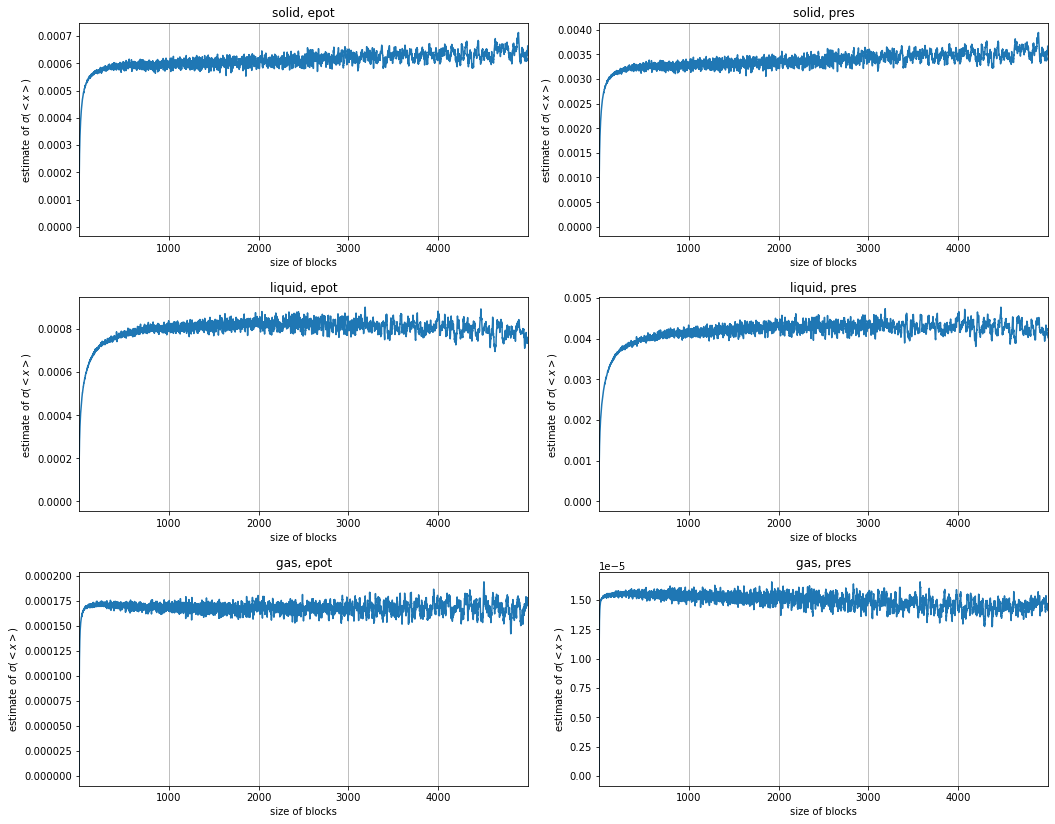

In [8]:
#please change the string below to "log" in order to plot the data logscale
mode = "linear"


x = range (len(sigmas[0][0]))


fig, axes = plt.subplots (3,2)
fig.set_size_inches (15,12)
fig.tight_layout (pad=4.)


for axx, sigmas_list , listnames in zip (axes, sigmas, filenames):
    for ax, sigmas_array ,filename in zip (axx, sigmas_list, listnames):
        ax.plot(x, sigmas_array)

        ax.set_yscale(mode)
        ax.set_ylabel ("estimate of $\sigma (<x>)$")
        
        ax.set_xscale(mode)
        ax.set_xlim([1,len (sigmas_array)])
        ax.grid (True, axis="x", which="both")
        ax.set_xlabel ("size of blocks")

        ax.set_title (regTitle.search(filename).group() + ', ' + regQuantity.search (filename).group())

A kind of saturation appears after size $\approxeq$ 300 for solid, size $\approxeq$ 700 for liquid and size $\approxeq$ 100 for gas (to see this better please set "log" option in the cell above). Actually, when plotting data in "linear" mode, the solid system seems not to saturate completely, even after size 5000, since the final average slope is different from 0.
Anyway, data for such sizes become too noisy to test the assertion; more simulation data would be needed

<h5>7-2/3/4: include the calculation of g(r) inside Monte_Carlo_NVT and MolDyn_NVE codes, and compare results from the two methods for a system of Argon in the solid, the liquid and the gaseous phase <h5> 

First, we replicate the preliminary anlysis we did above for the microcanonical system simulated by MolDyn code. We therefore perform simulation of the three phases with $5\times10^5\times imeasure$ steps each in order to find the autocorrelation length and the saturation size for blocks (there ought to be no need for an equilibration time since the system as the block averaging starts has already been equilibrated by Calibrate() function)

In [23]:
filenames = []

for name in names:
    filenames.append (["output_" + name + "_Ar/output.epot.0", "output_" + name + "_Ar/output.pres.0"] )
    
print (filenames)


dirname04 = "exercices/output/dir04"
filenames04 = []

for name in names:
    filenames04.append ([name + "_eq/output_epot.dat", name + "_eq/output_press.dat"])
    
print (filenames04)

datasets = []   
for listnames in filenames:
    tempdata=[] 
    for filename in  listnames:
        tempdata.append (measurements(nfields=4, nquantities=1, headed_file_name=dirname + '/' + filename))
    datasets.append (tempdata)

print ("finished loading Ar 07")
datasets04 = []
for listnames in filenames04:
    tempdata=[] 
    for filename in  listnames:
        tempdata.append (measurements(nfields=3, nquantities=1, 
                                      headed_file_name=dirname04 + '/' + filename, 
                                      consumeString = "End_Calibration",
                                      AddHeader = ["estimate","average","error"]))
    datasets04.append (tempdata)


print ("finished loading Ar 04")

[['output_solid_Ar/output.epot.0', 'output_solid_Ar/output.pres.0'], ['output_liquid_Ar/output.epot.0', 'output_liquid_Ar/output.pres.0'], ['output_gas_Ar/output.epot.0', 'output_gas_Ar/output.pres.0']]
[['solid_eq/output_epot.dat', 'solid_eq/output_press.dat'], ['liquid_eq/output_epot.dat', 'liquid_eq/output_press.dat'], ['gas_eq/output_epot.dat', 'gas_eq/output_press.dat']]
reading exercices/output/dir07/output_solid_Ar/output.epot.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_solid_Ar/output.pres.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_liquid_Ar/output.epot.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_liquid_Ar/output.p

In [24]:
correlations = []
sigmas = []
autocorr_ranges = [200, 300, 20000]
size_ranges = [1000, 1000, 10000]

for list_datasets , autocorr_range, size_range in zip (datasets04, autocorr_ranges, size_ranges):
    temp_corr = []
    temp_sigmas = []
    for dataset in list_datasets:
        temp_corr.append ( my.autocorrelation (dataset.data [0] ["estimate"], autocorr_range))
        temp_sigmas.append (my.block_sigmas (dataset.data [0] ["estimate"], range (size_range)))
    correlations.append (temp_corr)
    sigmas.append (temp_sigmas)



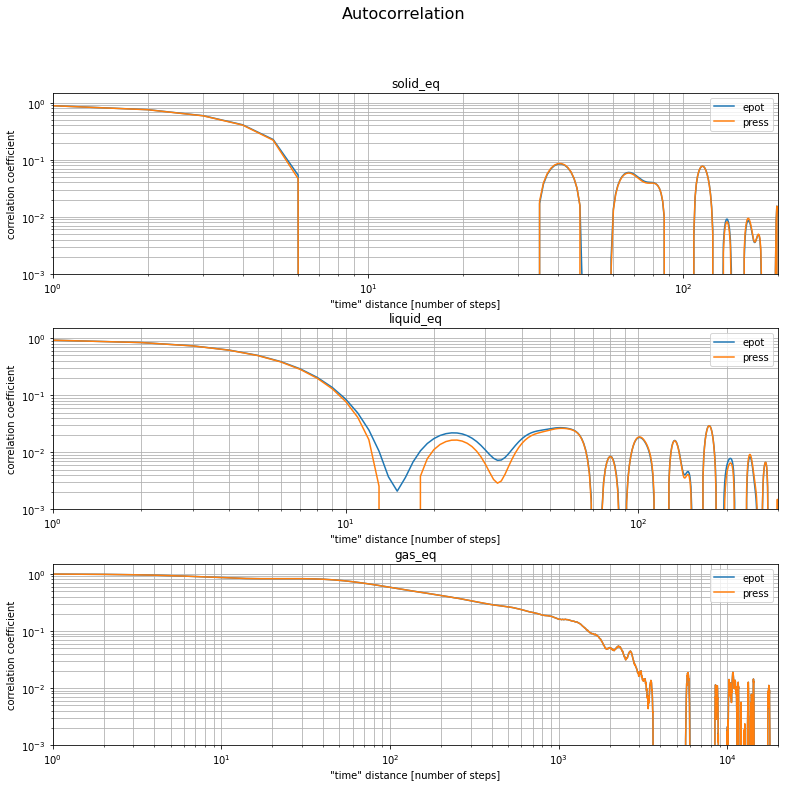

In [25]:


regQuantity = re.compile (r"(?<=put_)(\w*)")
regTitle = re.compile (r"(\w*)(?=/out)")

fig, axes = plt.subplots (3)
fig.set_size_inches (13,12)
fig.subplots_adjust (hspace=0.3)
fig.suptitle ("Autocorrelation", fontsize=16 )

for ax, aut_list , listnames in zip (axes, correlations, filenames04):
    x = range(aut_list[0].shape[0])
    for aut ,filename in zip (aut_list, listnames):
        ax.plot(x, aut, label=regQuantity.search (filename).group())
        
    
    ax.set_yscale("log")
    ax.set_ylim([10**(-3), 1.5])
    ax.set_xscale("log")
    ax.set_xlim([1,aut.shape[0]])
    ax.grid (True, axis="both", which="both")
    ax.legend ()
    ax.set_title (regTitle.search(filename).group())
    ax.set_ylabel ("correlation coefficient")
    ax.set_xlabel ("\"time\" distance [number of steps]")



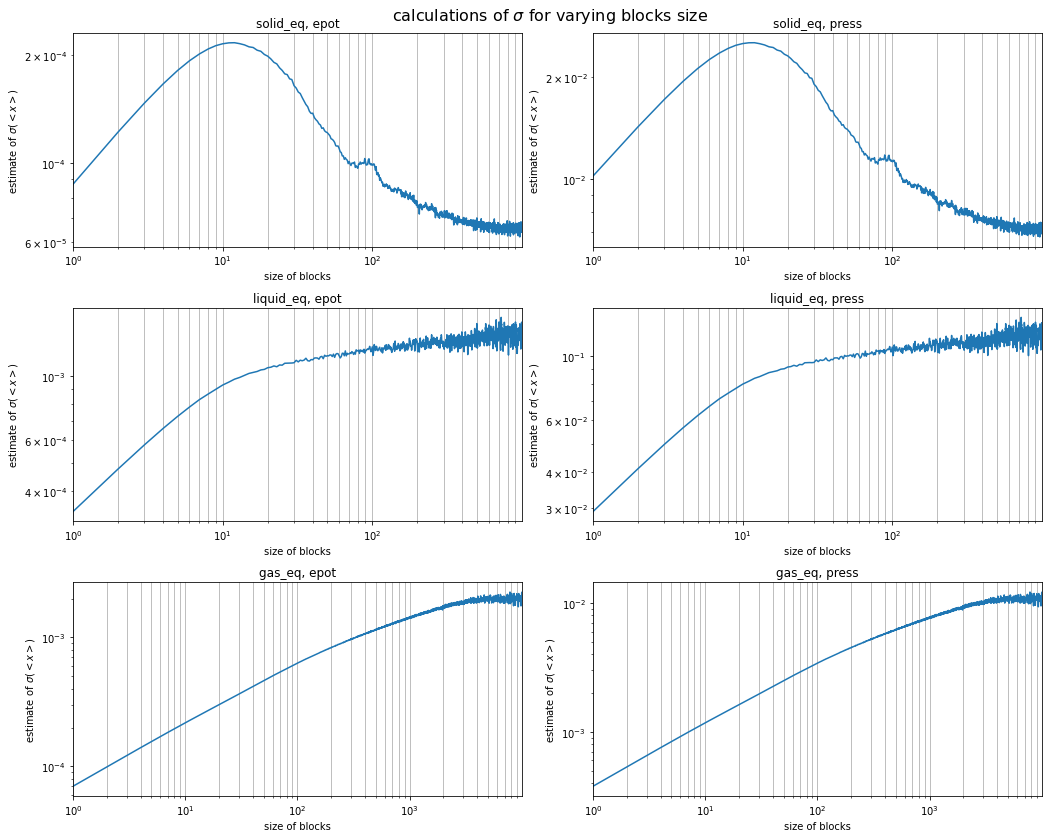

In [26]:
#please change the string below to "log" in order to plot the data logscale
mode = "log"


fig, axes = plt.subplots (3,2)
fig.set_size_inches (15,12)
fig.tight_layout (pad=4.)
fig.suptitle ("calculations of $\sigma$ for varying blocks size", fontsize=16)


for axx, sigmas_list , listnames in zip (axes, sigmas, filenames04):
    x = range (len(sigmas_list[0]))
    for ax, sigmas_array ,filename in zip (axx, sigmas_list, listnames):
        ax.plot(x, sigmas_array)

        ax.set_yscale(mode)
        ax.set_ylabel ("estimate of $\sigma (<x>)$")
        
        ax.set_xscale(mode)
        ax.set_xlim([1,len (sigmas_array)])
        ax.grid (True, axis="x", which="both")
        ax.set_xlabel ("size of blocks")

        ax.set_title (regTitle.search(filename).group() + ', ' + regQuantity.search (filename).group())

the three systems behave rather differently from one another. In the solid phase, the estimate of $\sigma(<\mu>)$ drops after the typical autocorrelation length of $\approxeq 10$; in the liquid one, its value almost saturates after size $10^2$, which is about 10 times the typical autocorrelation length;  in the gaseous phase, coherently with the autocorrelation plot, the value of $\sigma$ sturates at about $2\times10^4$ measurements. This matches well with an autocorrelation length of about $2\times10^3$ 

In conclusion, the sizes of blocks will be chosen to be: $100$ for solid and liquid phase, $2\times10^4$ for the gaseous phase

In [36]:
#load data for comparison with the results of ex04
filenames04 = []
dirname = "exercices/output/dir07"
dirname04 = "exercices/output/dir04"
names = ["solid", "liquid", "gas"]
filenames = []
for name in names:
    filenames.append (["output_" + name + "_Ar/output.epot.0", "output_" + name + "_Ar/output.pres.0"] )
    
    
print (names)
for name in names:
    filenames04.append ([name + "/output_epot.dat", name + "/output_press.dat"])
    
datasets = []   
for listnames in filenames:
    tempdata=[] 
    for filename in  listnames:
        tempdata.append (measurements(nfields=4, nquantities=1, headed_file_name=dirname + '/' + filename))
    datasets.append (tempdata)
    
print (filenames04)

datasets04 = []   
for listnames in filenames04:
    tempdata=[] 
    for filename in  listnames:
        tempdata.append (measurements(nfields=3, nquantities=1, 
                                      headed_file_name=dirname04 + '/' + filename, 
                                      consumeString="End_Calibration",
                                      AddHeader=["iblok", "average", "error"]
                                      ))
    datasets04.append (tempdata)


print ("finished loading")

['solid', 'liquid', 'gas']
reading exercices/output/dir07/output_solid_Ar/output.epot.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_solid_Ar/output.pres.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_liquid_Ar/output.epot.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_liquid_Ar/output.pres.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/output_gas_Ar/output.epot.0
found headers:  ['iblock', 'estimate', 'average', 'error']
['iblock', 'estimate', 'average', 'error']  used as dictionary keys
reading exercices/output/dir07/ou

Now, we add the pressure and g(r) calculation to MolDyn code, and the former we add to Monte_Carlo_NVT code too. In order to compare results, we must also add to MolDyn code the tail corrections for the potential energy and pressure. Finally, the results are converted to IS units by means of the same class already used in es04

In [37]:
#Argon constants for conversion to SI units
kb = 1.38064852e-23 #boltzmann constant
nA = 6.02214076e23 #avogadro number
epsilon = 120 * kb
sigma = 0.34e-9
m = 39.948 / nA / 1000 

conv = my.Converter( epsilon, sigma, m)


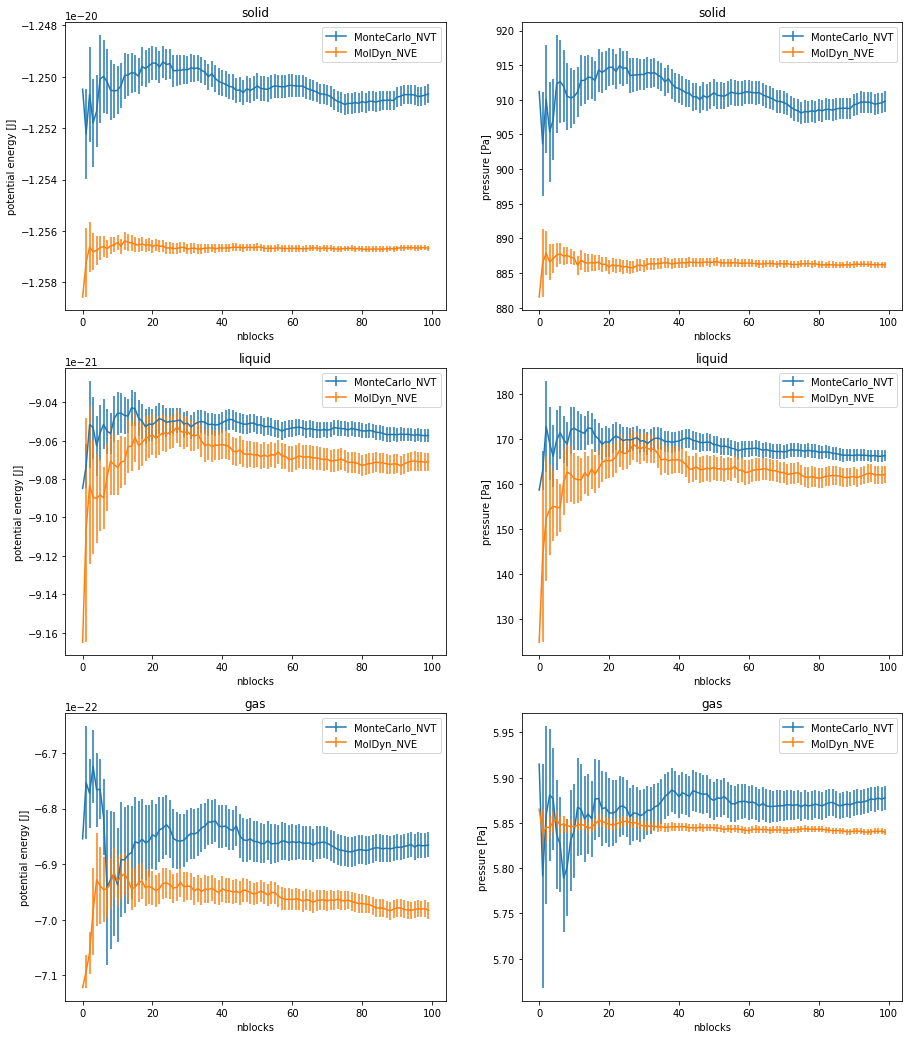

In [39]:
#plot comparison 04-07
x = range(100) #we have choose to make 100 blocks for every simulation

fig, axes = plt.subplots (3,2)
fig.set_size_inches (15, 18)

for name, axx, list_datasets, list_datasets04, in zip (names, axes, datasets, datasets04):
    for dataset, dataset04, key, ax , quantity in zip (list_datasets, list_datasets04, ["potential energy [J]", "pressure [Pa]"], axx, ["E","temp"]):
        ax.errorbar (range (dataset.data[0]["average"].shape[0]), 
                     conv.convert (dataset.data[0]["average"], quantity), 
                     conv.convert (dataset.data[0]["error"], quantity), 
                     label="MonteCarlo_NVT"
                    )
        ax.errorbar (range (dataset04.data[0]["average"].shape[0]), 
                     conv.convert (dataset04.data[0]["average"], quantity), 
                     conv.convert (dataset04.data[0]["error"], quantity), 
                     label="MolDyn_NVE"
                    )       
        
        ax.set_title (name)
        ax.set_ylabel (key)
        ax.set_xlabel ("nblocks")
        ax.legend()
        

        
        
        
        

It can be seen that the calculated averages are almost compatible, except for the solid system; but this can be explained by noticing that the achieved reduced temperature in MolDyn solid phase is about 7.6, whereas the constant temperature in Monte_Carlo_NVT is 0.8. For the other two phases, a much better approximetion of the target temperature could be achieved. Therefore, the two systems labelled as "solid" are actually different, and different averages values should be no wonder. 

Next, we compare g(r) obtained from the two algorithms:

In [42]:
dirname04 = "exercices/output/dir04"
dirname = "exercices/output/dir07"
names = ["solid", "liquid", "gas"]

gofrdat = []
gofrdat04 = []
for name in names :
    gofrdat.append (measurements( 1, 2, 
                                 dirname + "/output_" + name + "_Ar/output.gave.0", 
                                 AddHeader=["binvalue", "binerror"]
                                )
                   )
    gofrdat04.append (measurements( 1, 2, 
                                     dirname04 + '/' + name + "/output_g(r).dat",
                                     consumeString="End_Calibration", 
                                     AddHeader=["binvalue", "binerror"]
                                  )
                     )

print ("finished loading")

reading exercices/output/dir07/output_solid_Ar/output.gave.0
found headers:  ['0', '0']
assigning key values  ['binvalue', 'binerror']  passed as argument
reading exercices/output/dir04/solid/output_g(r).dat
found headers:  ['0', '0']
assigning key values  ['binvalue', 'binerror']  passed as argument
reading exercices/output/dir07/output_liquid_Ar/output.gave.0
found headers:  ['0', '0']
assigning key values  ['binvalue', 'binerror']  passed as argument
reading exercices/output/dir04/liquid/output_g(r).dat
found headers:  ['0', '0']
assigning key values  ['binvalue', 'binerror']  passed as argument
reading exercices/output/dir07/output_gas_Ar/output.gave.0
found headers:  ['0', '0']
assigning key values  ['binvalue', 'binerror']  passed as argument
reading exercices/output/dir04/gas/output_g(r).dat
found headers:  ['0', '0']
assigning key values  ['binvalue', 'binerror']  passed as argument
finished loading


In [45]:

#we define a function for obtaining the box size as a function of the number of particles and number density, 
#that we can retrieve from "input.dat"    
def reduced_boxsize (npart, rho):
    return (npart / rho) ** (1./3.)




boxsizes = []
for name in names:
    with open (dirname04 + '/' + name + "/input.dat", encoding="utf8") as infile04, open (dirname + "/output_" + name + "_Ar/input.dat",encoding="utf8") as infile07:
        tempsizes = []
        for infile in [infile07, infile04]:
            next(infile)
            npart = float(str(infile.readline()))
            rho = float(str(infile.readline()))
            print ("number of particeles: " , npart, " number density: " ,rho )
            tempsizes.append (conv.convert (reduced_boxsize (npart, rho), "length"))
        boxsizes.append (tempsizes)


number of particeles:  108.0  number density:  1.1
number of particeles:  108.0  number density:  1.1
number of particeles:  108.0  number density:  0.8
number of particeles:  108.0  number density:  0.8
number of particeles:  108.0  number density:  0.05
number of particeles:  108.0  number density:  0.05


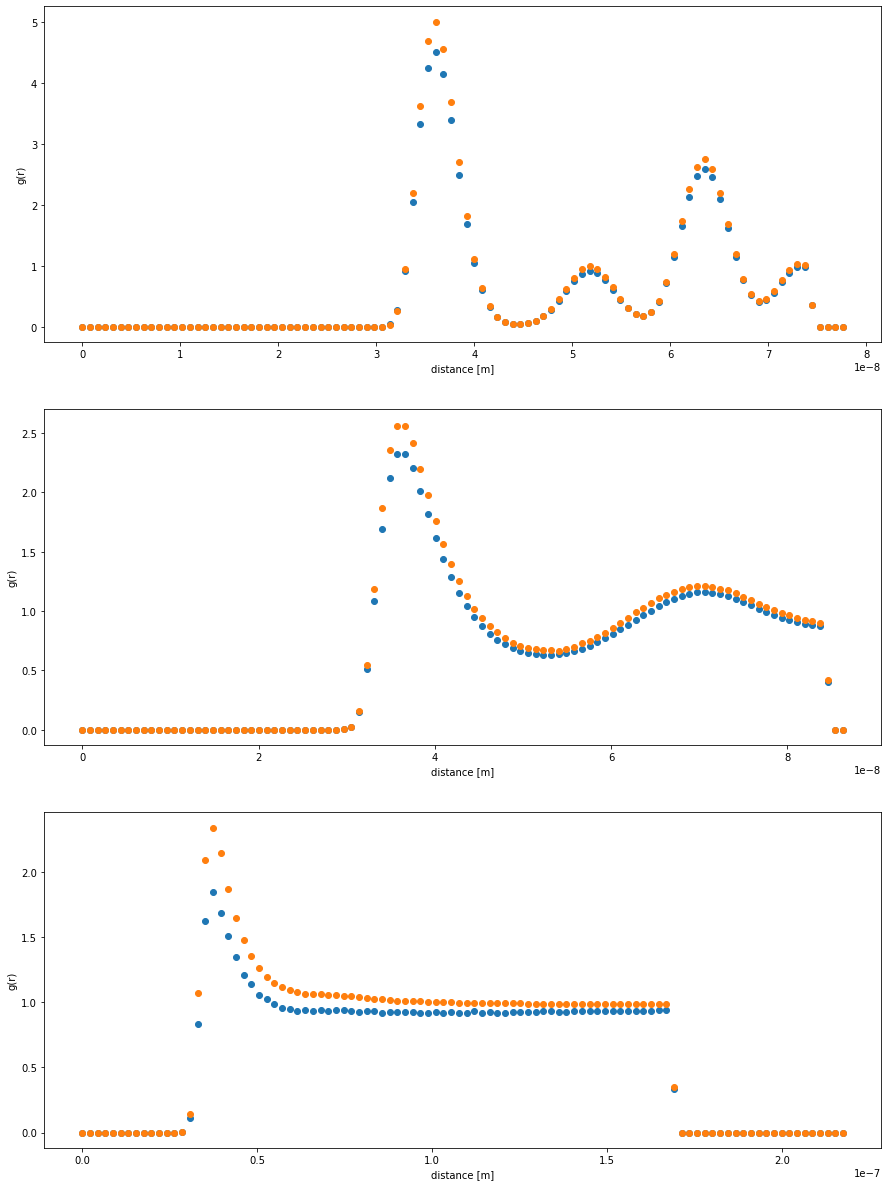

In [44]:
#plot g(r)
fig, axes = plt.subplots (3,1)
fig.set_size_inches (15, 21)

for ax, name, boxsize, gofr, gofr04 in zip (axes, names, boxsizes, gofrdat, gofrdat04):
    for g , size, label in zip ([gofr, gofr04], boxsize, ["Monte_Carlo_NVT", "MolDyn_NVE"]):
        ax.errorbar (np.array(range (g.data[0]["binvalue"].shape[0])) * size / 2, 
                     g.data[0]["binvalue"] , 
                     g.data[0]["binerror"] , fmt='o', label=label)
    ax.set_xlabel ("distance [m]")
    ax.set_ylabel ("g(r)")

One can observe that in the solid phase, there are chief and secondary peaks, reflecting the adjacent and diagonal nearest neighbours shells in the chrystalline structure. In the liquid phase, one can see the isotropic first and second shells of nearest neighbours, corresponding to the two peaks. In the gas, only the firs peak can be seen, since the system is both more unordered and less interactive, bringing to no second nearest neighbours shell to appear (the information of a particle being in the origin is less relevant to determining the positions of the others). In all graphs, both the effects of the repulsive hard core (which is smaller at higher temperatures, i.e. higer kinetic energies) and that of the cut-off radius can be seen. The gaseous phase also allows us to appreciate the asymptotic behaviour of $g(r)$, whoose limit is $1$ for big radius

The graphs obtained with the two different methods match quite well, even though, according to the calculated errors, (error bars are not visible in the figure) they are not fully compatible. It is possible that errors have been somehow underestimated, or, more likely, the two algorithms do not deal with fully equivalent systems. For instance, the temperature that one is able to achieve by restarting Verlet's algorithm several times is never exactly the target one; moreover, Verlet and Metropolis moves transform the system differently (for example, they  preserve different quantities)